In [1]:
#Laoding libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
#Reading and Transforming 'message-demo.csv' file in pandas dataframe
messages_df = pd.read_csv('messages-demo.csv', index_col='message_id')

C:\Users\kisha\AppData\Local\Temp\ipykernel_19652\2995746994.py:2: DtypeWarning: Columns (7,8,16,17,19,21,23,25,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  messages_df = pd.read_csv('messages-demo.csv', index_col='message_id')


In [3]:
#Deleting uneccessary columns from 'messages_df' dataframe
messages_df.drop(labels=['id', 'created_at', 'updated_at', 'category'], inplace=True, axis=1)

In [4]:
#Changing datatypes of mesages dataset (messages_df) attributes
messages_df['campaign_id'] = messages_df['campaign_id'].astype('Int64')
messages_df['client_id'] = messages_df['client_id'].astype('Int64')

#Creating a method which will convert string characters into boolean value
def convert_to_bool(value):
    if value == 't':
        return True
    else:
        return False
#Changing datatypes of mesages dataset (messages_df) attributes
messages_df['is_opened'] = messages_df['is_opened'].apply(convert_to_bool)
messages_df['is_clicked'] = messages_df['is_clicked'].apply(convert_to_bool)
messages_df['is_unsubscribed'] = messages_df['is_unsubscribed'].apply(convert_to_bool)
messages_df['is_hard_bounced'] = messages_df['is_hard_bounced'].apply(convert_to_bool)
messages_df['is_soft_bounced'] = messages_df['is_soft_bounced'].apply(convert_to_bool)
messages_df['is_complained'] = messages_df['is_complained'].apply(convert_to_bool)
messages_df['is_blocked'] = messages_df['is_blocked'].apply(convert_to_bool)
messages_df['is_purchased'] = messages_df['is_purchased'].apply(convert_to_bool)

In [5]:
#Changing datatypes of mesages dataset (messages_df) attributes
messages_df['date'] = pd.to_datetime(messages_df['date'])
messages_df['sent_at'] = pd.to_datetime(messages_df['sent_at'])
messages_df['opened_first_time_at'] = pd.to_datetime(messages_df['opened_first_time_at'])
messages_df['opened_last_time_at'] = pd.to_datetime(messages_df['opened_last_time_at'])
messages_df['clicked_first_time_at'] = pd.to_datetime(messages_df['clicked_first_time_at'])
messages_df['clicked_last_time_at'] = pd.to_datetime(messages_df['clicked_last_time_at'])
messages_df['unsubscribed_at'] = pd.to_datetime(messages_df['unsubscribed_at'])
messages_df['hard_bounced_at'] = pd.to_datetime(messages_df['hard_bounced_at'])
messages_df['soft_bounced_at'] = pd.to_datetime(messages_df['soft_bounced_at'])
messages_df['complained_at'] = pd.to_datetime(messages_df['complained_at'])
messages_df['blocked_at'] = pd.to_datetime(messages_df['blocked_at'])
messages_df['purchased_at'] = pd.to_datetime(messages_df['purchased_at'])

In [6]:
messages_df['is_purchased'] = messages_df['is_purchased'].apply(lambda x: 1 if x is True else 0)
messages_df['is_opened'] = messages_df['is_opened'].apply(lambda x: 1 if x is True else 0)
messages_df['is_clicked'] = messages_df['is_clicked'].apply(lambda x: 1 if x is True else 0)
messages_df['is_unsubscribed'] = messages_df['is_unsubscribed'].apply(lambda x: 1 if x is True else 0)
messages_df['is_hard_bounced'] = messages_df['is_hard_bounced'].apply(lambda x: 1 if x is True else 0)
messages_df['is_soft_bounced'] = messages_df['is_soft_bounced'].apply(lambda x: 1 if x is True else 0)
messages_df['is_complained'] = messages_df['is_complained'].apply(lambda x: 1 if x is True else 0)
messages_df['is_blocked'] = messages_df['is_blocked'].apply(lambda x: 1 if x is True else 0)
messages_df['is_purchased'] = messages_df['is_purchased'].apply(lambda x: 1 if x is True else 0)

In [7]:
messages_df['Hour'] = messages_df['sent_at'].dt.hour

In [8]:
def time_periods(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    else:
        return 'Evening'
#Apply the custom function to the 'hour' column and create a new 'period' column
messages_df['TimePeriod'] = messages_df['Hour'].apply(time_periods)

In [9]:
#===Converting the 'message_type' values into dummy variables=================================
final_message_df = pd.get_dummies(messages_df, columns=['message_type','TimePeriod','channel'])

In [10]:
#Taking 6 columns from 'messages_df' to create a new dataframe 'final_message_df' for predictive analysis
final_message_df = final_message_df[['message_type_bulk','message_type_transactional','message_type_trigger','is_opened','is_soft_bounced','is_hard_bounced','is_complained','is_blocked','is_purchased','TimePeriod_Afternoon', 'TimePeriod_Evening',
       'TimePeriod_Morning', 'TimePeriod_Night','channel_email',
       'channel_mobile_push', 'channel_web_push']]

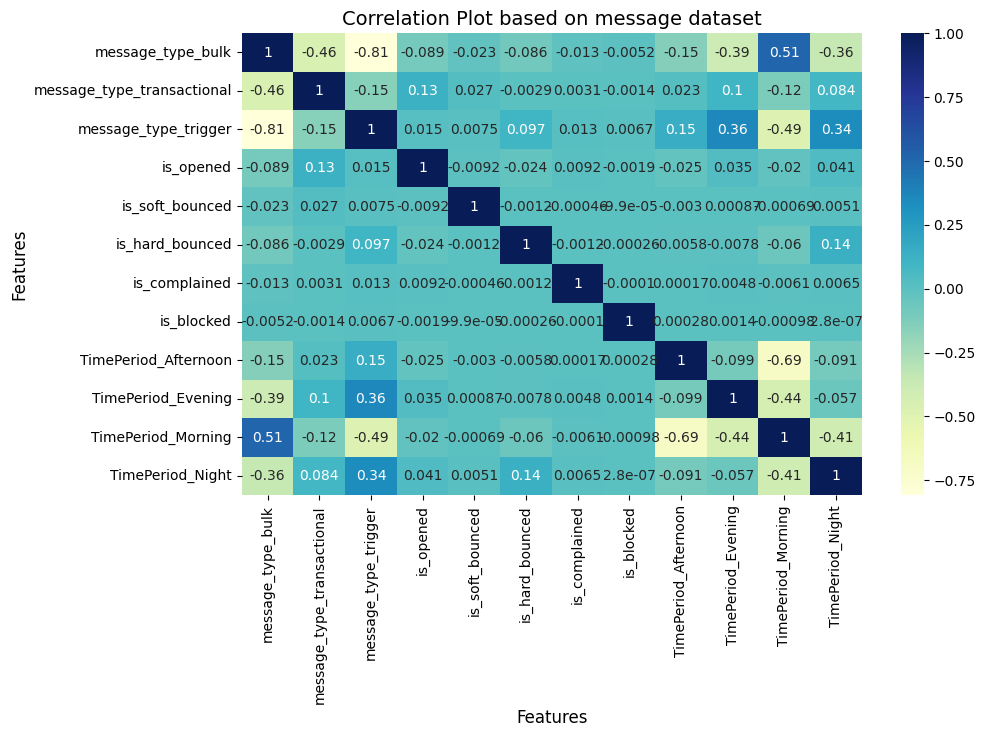

In [95]:
columns = ['message_type_bulk', 'message_type_transactional',
       'message_type_trigger', 'is_opened', 'is_soft_bounced',
       'is_hard_bounced', 'is_complained', 'is_blocked','TimePeriod_Afternoon', 'TimePeriod_Evening', 'TimePeriod_Morning',
       'TimePeriod_Night']

correlation_matrix = final_message_df[columns].corr()
# Create a correlation plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
# Add plot title and adjust font size
plt.title('Correlation Plot based on message dataset', fontsize=14)
# Set the font size of the axis labels
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Show the plot
plt.show()

In [71]:
# Assume 'df' is your original DataFrame
minority_class = final_message_df[final_message_df['is_opened'] == 1]
majority_class = final_message_df[final_message_df['is_opened'] == 0]

# Randomly oversample the minority class
minority_oversampled = minority_class.sample(len(majority_class), replace=True)

# Combine oversampled minority class with majority class
resampled_message_df = pd.concat([majority_class, minority_oversampled])

In [72]:
###==========================Light GBM ===================================(By Abhishek)

columns = ['is_opened','is_purchased']
X = resampled_message_df.drop(columns, axis=1)

#Using 'message_type_in_numerical_form' as a target variable
y = resampled_message_df['is_opened']

#Define the list of X (Independent Variable features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Creating a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
# Defining the LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'lambda_l1': 0.1,  # L1 regularization (Lasso-like)
    'lambda_l2': 0.1,  # L2 regularization (Ridge-like)
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Training the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)
# Making predictions on the testing data
y_pred_lgb = model.predict(X_test)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_lgb]
# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.5696779686381173


In [73]:
#=======================Classification Report based on Light Gradient Boost======================
from sklearn.metrics import classification_report
report_lgb = classification_report(y_test, y_pred_binary)
print(report_lgb)
#=================================================================================================

              precision    recall  f1-score   support

           0       0.59      0.46      0.52   1677259
           1       0.56      0.68      0.61   1677259

    accuracy                           0.57   3354518
   macro avg       0.57      0.57      0.56   3354518
weighted avg       0.57      0.57      0.56   3354518



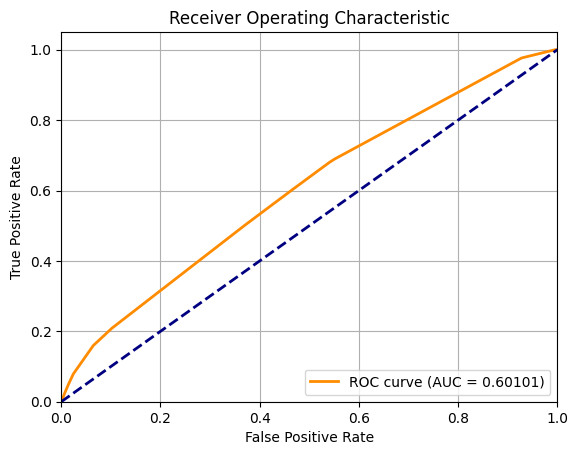

In [78]:
#============================ROC Curve for lightGBM model=============================================
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

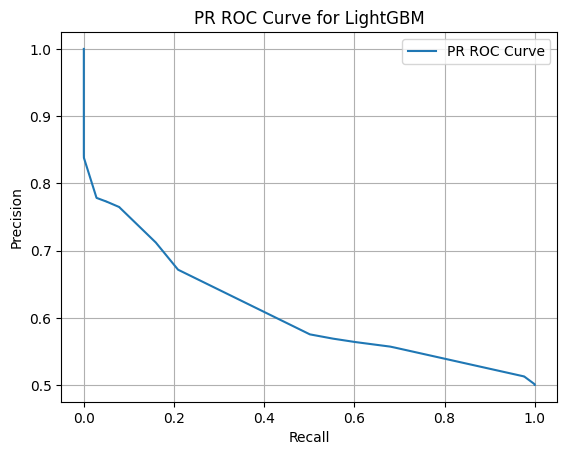

In [80]:
#============================PR ROC Curve for lightGBM model=============================================
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_lgb)
plt.plot(recall, precision, label='PR ROC Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR ROC Curve for LightGBM')
plt.legend()
plt.grid()
plt.show()

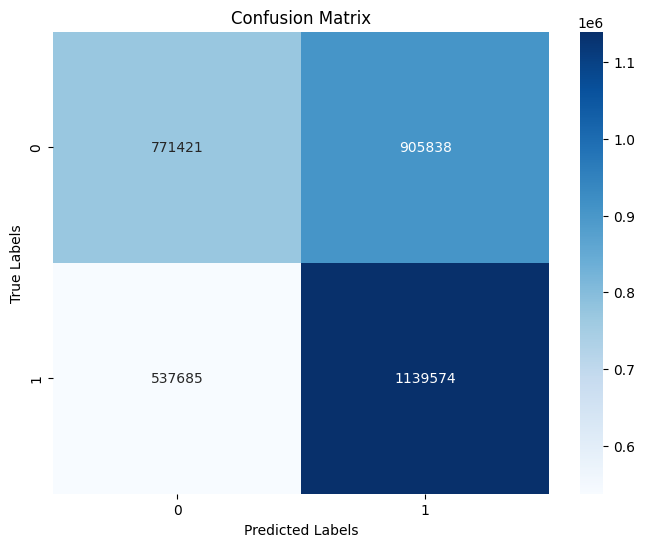

In [82]:
#============================Confusion Matrix for lightGBM model=============================================
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [84]:
columns = ['message_type_bulk', 'TimePeriod_Afternoon',
       'message_type_trigger','is_complained', 'is_blocked', 'is_purchased',
       'TimePeriod_Evening', 'channel_mobile_push', 'channel_web_push']
X = final_message_df.drop(columns, axis=1)

minority_class = X[X['is_opened'] == 1]
majority_class = X[X['is_opened'] == 0]

# Randomly oversample the minority class
minority_oversampled = minority_class.sample(len(majority_class), replace=True)

# Combine oversampled minority class with majority class
resampled_message_df = pd.concat([majority_class, minority_oversampled])

In [85]:
#=====================================Decision Tree========================================================
# Splitting the data into features (X) and target (y)
columns = ['is_opened']
X = resampled_message_df.drop(columns, axis=1)

#Using 'message_type_in_numerical_form' as a target variable
y = resampled_message_df['is_opened']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

clf = DecisionTreeClassifier()

# Fitting the classifier to the training data
clf.fit(X_train, y_train)

# Making predictions on the testing data
y_pred_dt = clf.predict(X_test)

# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

Accuracy: 0.5690424078809534


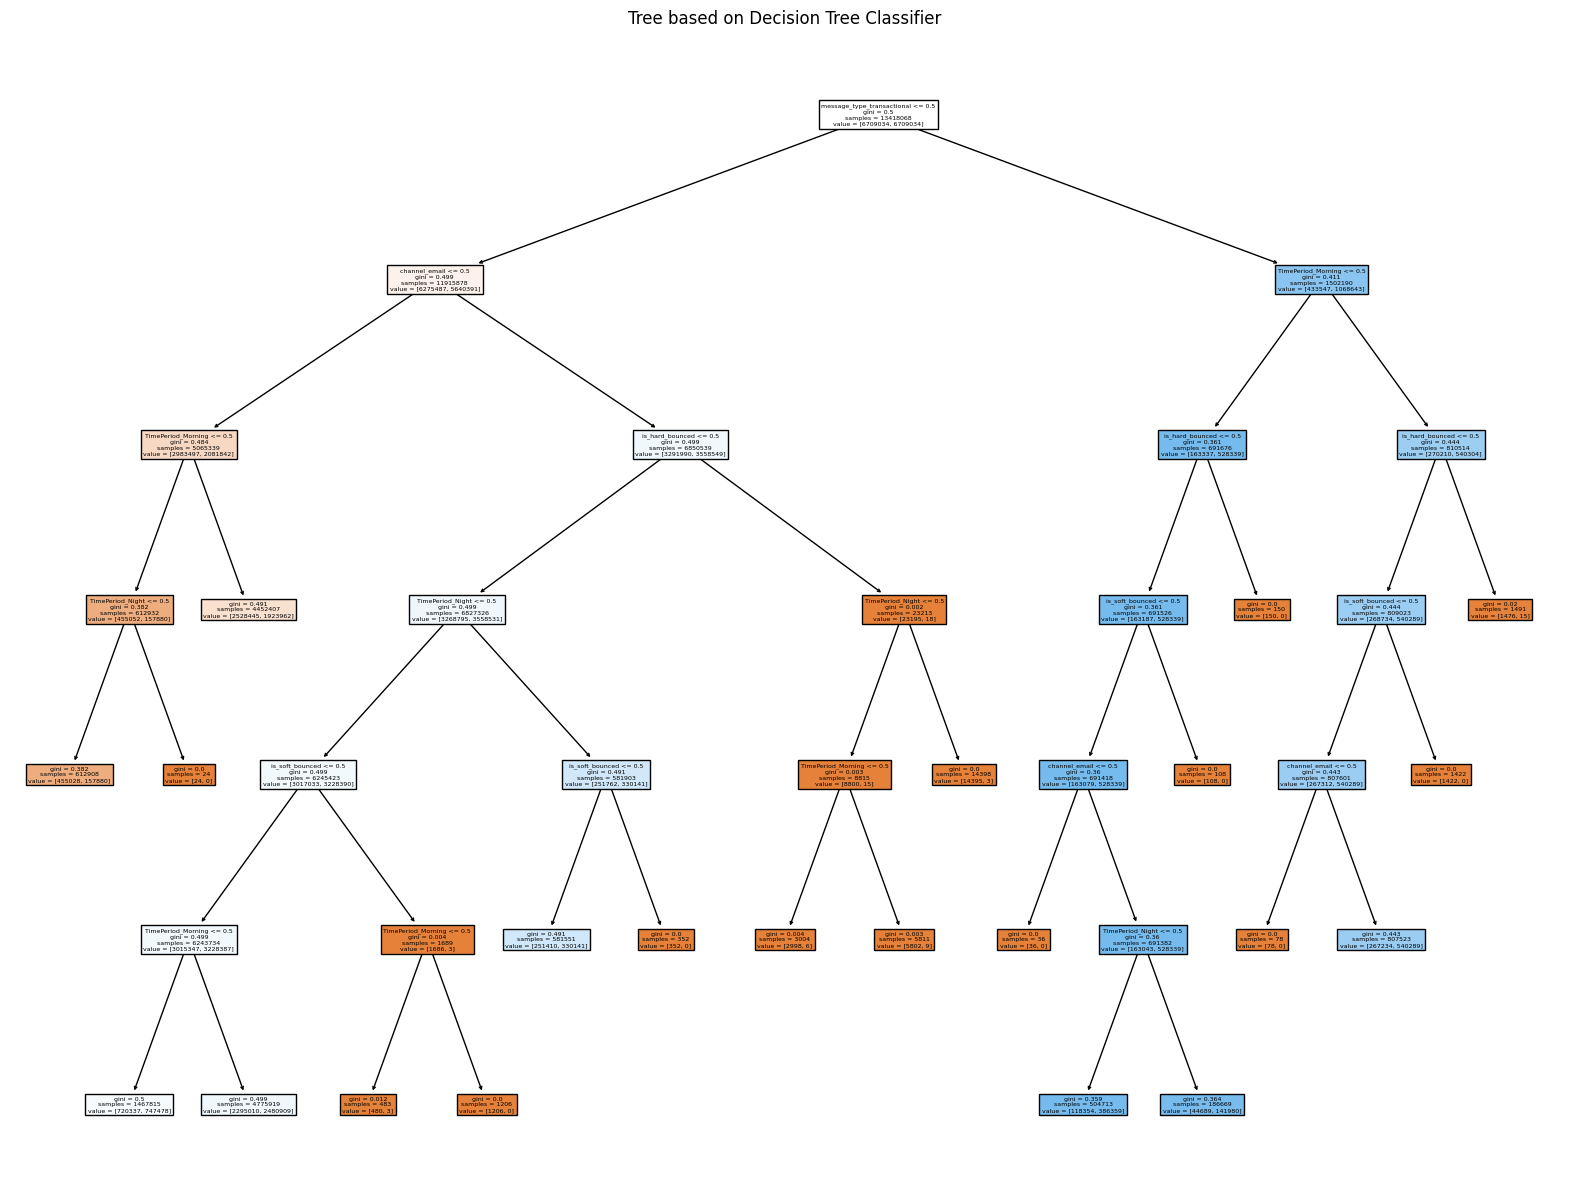

In [86]:
#=============================================Implementing the Decision Tree Graph=======================================
from sklearn import tree
fig = plt.figure(figsize=(20,15))
d = tree.plot_tree(clf, 
                   feature_names=X_test.columns, 
                   filled=True)
plt.title('Tree based on Decision Tree Classifier')
plt.show()

In [87]:
#=======================Classification Report based on Decision Tree=============================
report_dt = classification_report(y_test, y_pred_dt)
print(report_dt)
#=================================================================================================

              precision    recall  f1-score   support

           0       0.59      0.45      0.51   1677259
           1       0.56      0.69      0.62   1677259

    accuracy                           0.57   3354518
   macro avg       0.57      0.57      0.56   3354518
weighted avg       0.57      0.57      0.56   3354518



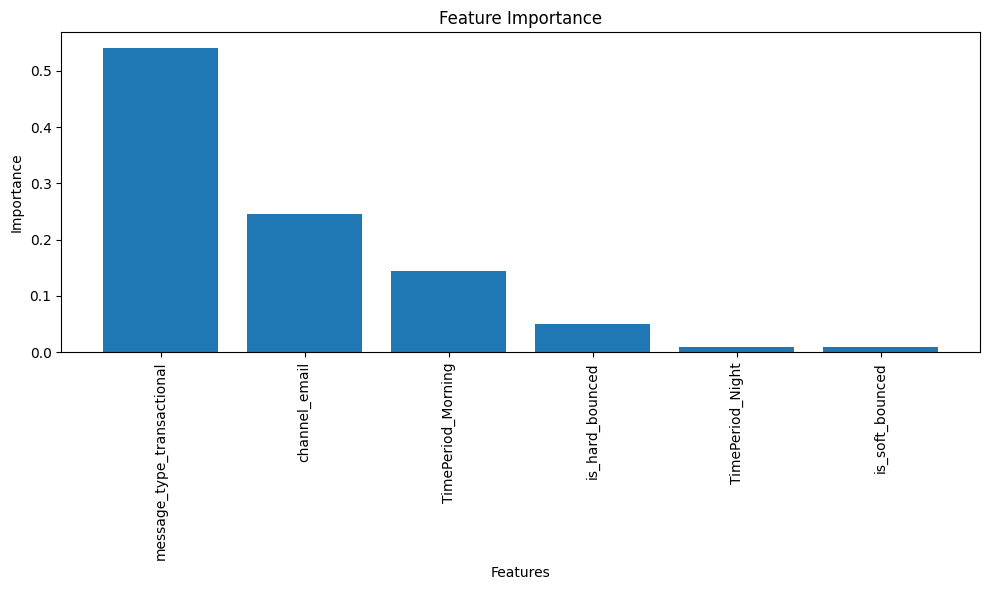

In [88]:
# Get the feature importances
importances = clf.feature_importances_

# Create a dataframe with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance values in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

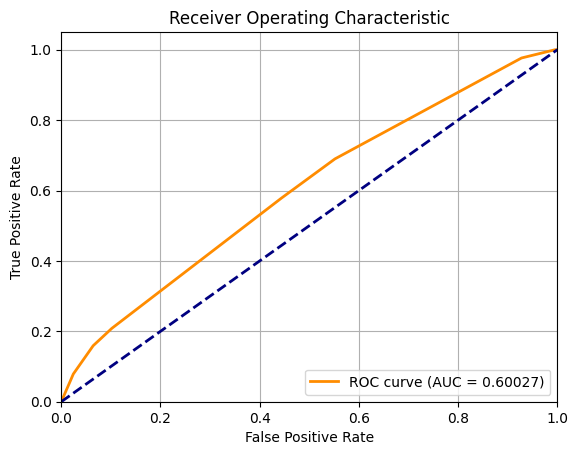

In [89]:
#============================ROC Curve for Decision Tree model=============================================
#Make predictions on the test set
y_scores = clf.predict_proba(X_test)[:, 1] 

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

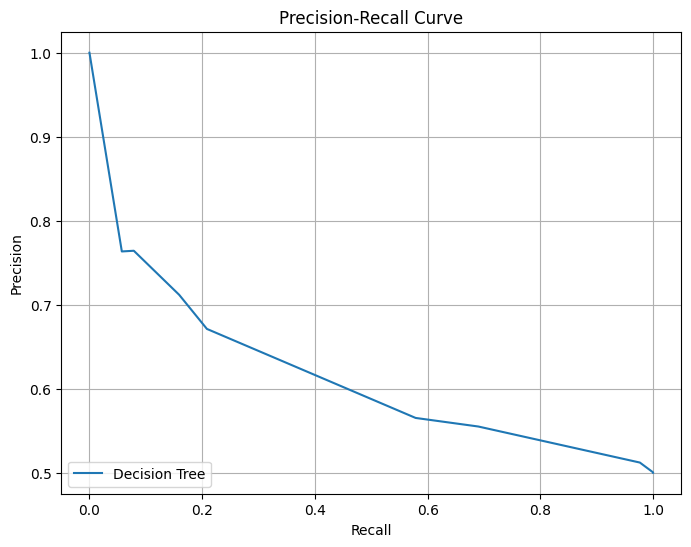

In [91]:
#============================PR ROC Curve for Decision Tree model=============================================
# Calculating the precision, recall, and thresholds
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_scores)
# Plotting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label='Decision Tree')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

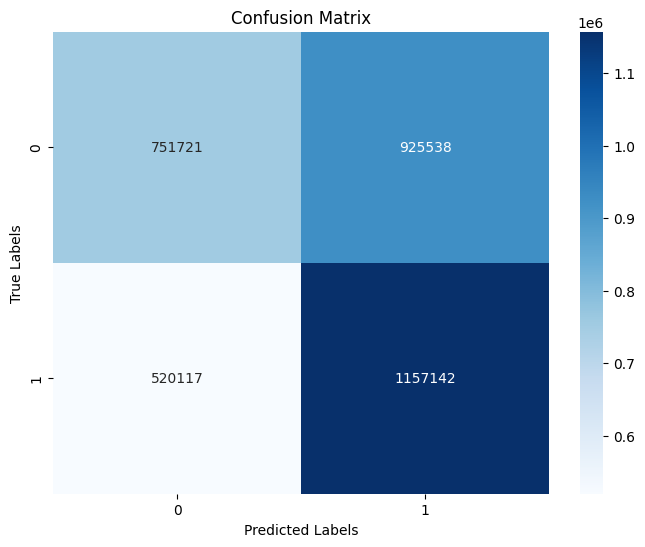

In [93]:
#=================================Calculate the confusion matrix for Decision Tree==========================================
cm = confusion_matrix(y_test, y_pred_dt)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

# Preprocessing
# Feature selection and engineering

columns = ['is_opened']
X = resampled_message_df.drop(columns, axis=1)

#Using 'message_type_in_numerical_form' as a target variable
y = resampled_message_df['is_opened']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Initialize and train the GBM model
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbm.predict(X_test)        

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5688411867219076


In [44]:
from sklearn.metrics import classification_report
# Evaluating the accuracy of the model
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.45      0.51   1677259
           1       0.56      0.69      0.62   1677259

    accuracy                           0.57   3354518
   macro avg       0.57      0.57      0.56   3354518
weighted avg       0.57      0.57      0.56   3354518



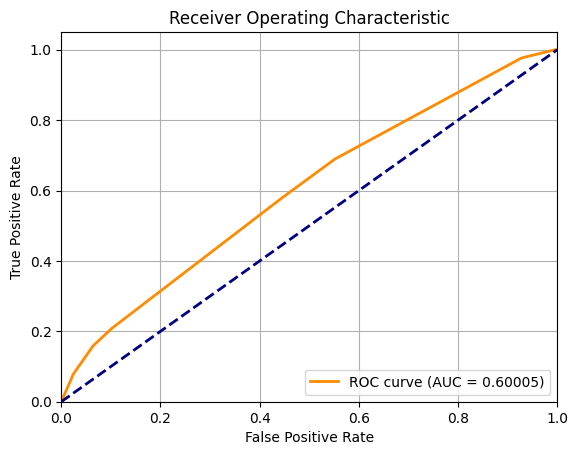

In [47]:
# Calculate the probabilities of positive class for ROC and PR curves
y_pred_prob = gbm.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

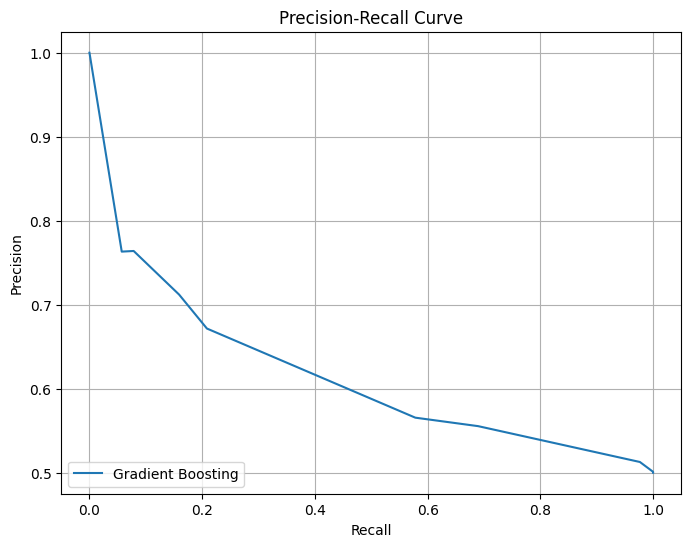

In [70]:
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_pred_prob)
# Plotting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label='Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

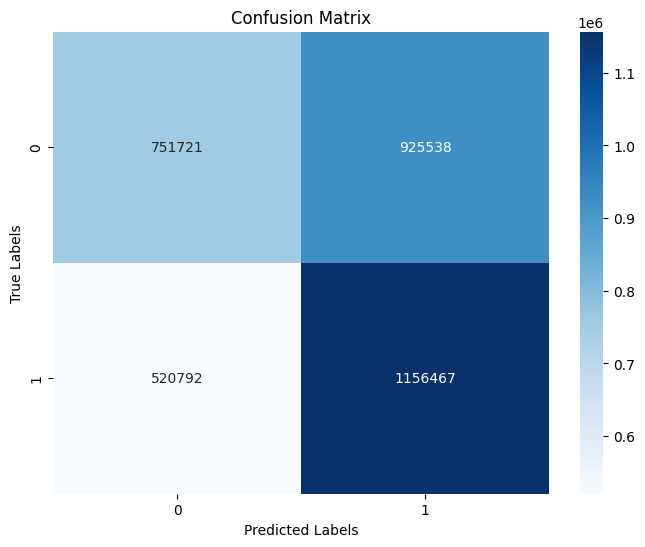

In [50]:
cm = confusion_matrix(y_test, y_pred)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [57]:
# Assume 'df' is your original DataFrame
minority_class = final_message_df[final_message_df['is_opened'] == 1]
majority_class = final_message_df[final_message_df['is_opened'] == 0]

# Randomly oversample the minority class
minority_oversampled = minority_class.sample(len(majority_class), replace=True)

# Combine oversampled minority class with majority class
resampled_message_df = pd.concat([majority_class, minority_oversampled])

In [67]:
#======================= Logistic Regression====================(By Anqi Pu)
from sklearn.linear_model import LogisticRegression

columns = ['is_opened']
X = resampled_message_df.drop(columns, axis=1)

#Using 'message_type_in_numerical_form' as a target variable
y = resampled_message_df['is_opened']

#Define the list of X (Independent Variable features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


#Using 'message_type_in_numerical_form' as a target variable
clf_LR = LogisticRegression()

# Fitting the classifier to the training data
clf_LR.fit(X_train, y_train)

# Making predictions on the testing data
y_pred_LR = clf_LR.predict(X_test)

# Evaluating the accuracy of the model
accuracy_LR = accuracy_score(y_test, y_pred_LR)
print("Accuracy:", accuracy_LR)

Accuracy: 0.5682244066062546


In [59]:
#=======================Hyperparameter Tuning====================(By Anqi Pu)
from sklearn.model_selection import GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs']
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(clf_LR, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
accuracy = best_model.score(X_test, y_test)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)

Best Hyperparameters: {'C': 0.1, 'solver': 'liblinear'}
Accuracy: 0.5682244066062546


In [60]:
from sklearn.metrics import classification_report

# Predict the target labels for the test set
y_pred = best_model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.51      0.54   1677259
           1       0.56      0.63      0.59   1677259

    accuracy                           0.57   3354518
   macro avg       0.57      0.57      0.57   3354518
weighted avg       0.57      0.57      0.57   3354518



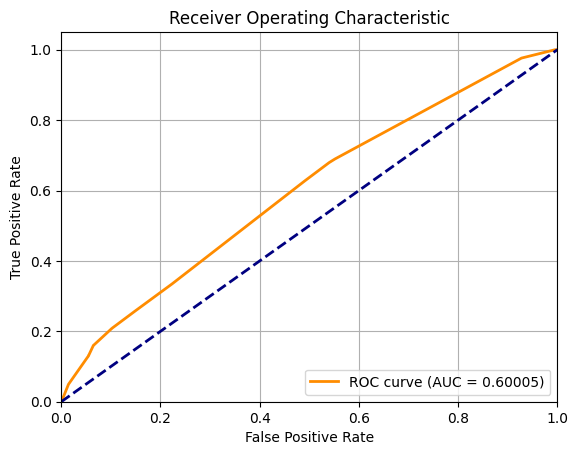

In [62]:
# Make predictions on the test set
from sklearn.metrics import roc_auc_score
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate the fpr and tpr for different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC (Area Under the Curve) score
auc = roc_auc_score(y_test, y_scores)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

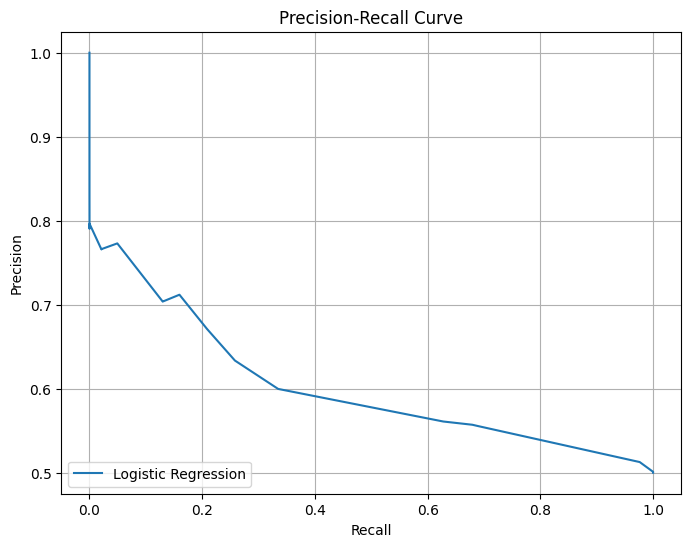

In [69]:
precision_dt ,recall_dt, thresholds_dt = precision_recall_curve(y_test, y_scores)
# Plotting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

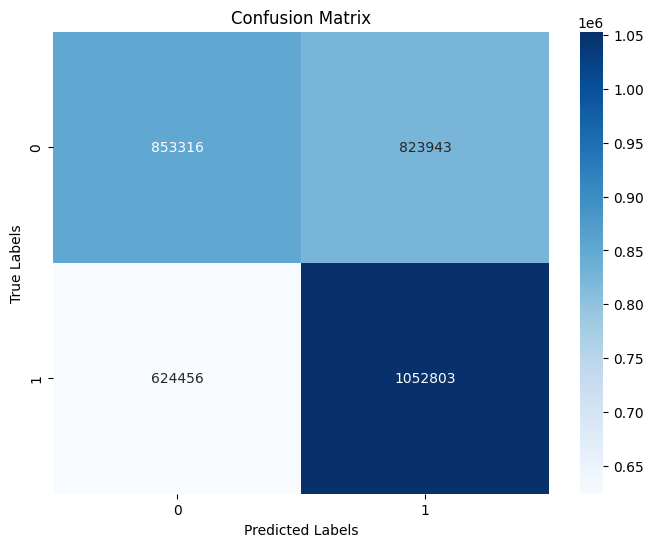

In [63]:
cm = confusion_matrix(y_test, y_pred)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()